# Содержание
1. [Условия задачи](#introduction)
2. [EDA](#paragraph1)
    1. [Определение покупки](#subparagraph1)
3. [Задание 1](#paragraph2)
4. [Задание 2](#paragraph3)
5. [Задание 3](#paragraph4)
6. [Задание 4](#paragraph5)
7. [Задание 5](#paragraph6)
8. [Задание 6 RFM-анализ](#paragraph7)
9. [Выводы и рекомендации](#paragraph8)



##  <a name="introduction"></a>
<h1>
    <span style="color:darkgrey">
         ПРОЕКТ E-COMMERCE
    </span>
</h1></h1>

**Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:**
1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.
6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик `recency`, `frequency` и `monetary` для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

**Файлы:
 
- `olist_customers_datase.csv` — таблица с уникальными идентификаторами пользователей
    - `customer_id` — позаказный идентификатор пользователя
    - `customer_unique_id` —  уникальный идентификатор пользователя  (аналог номера паспорта)
    - `customer_zip_code_prefix` —  почтовый индекс пользователя
    - `customer_city` —  город доставки пользователя
    - `customer_state` —  штат доставки пользователя

- `olist_orders_dataset.csv` —  таблица заказов
    - `order_id` —  уникальный идентификатор заказа (номер чека)
    - `customer_id` —  позаказный идентификатор пользователя
    - `order_status` —  статус заказа
    - `order_purchase_timestamp` —  время создания заказа
    - `order_approved_at` —  время подтверждения оплаты заказа
    - `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
    - `order_delivered_customer_date` —  время доставки заказа
    - `order_estimated_delivery_date` —  обещанная дата доставки
    
- `olist_order_items_dataset.csv` —  товарные позиции, входящие в заказы
    - `order_id` —  уникальный идентификатор заказа (номер чека)
    - `order_item_id` —  идентификатор товара внутри одного заказа
    - `product_id` —  ид товара (аналог штрихкода)
    - `seller_id` — ид производителя товара
    - `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
    - `price` —  цена за единицу товара
    - `freight_value` —  вес товара

*Уникальные статусы заказов в таблице olist_orders_dataset:

`created` —  создан
`approved` —  подтверждён
`invoiced` —  выставлен счёт
`processing` —  в процессе сборки заказа
`shipped` —  отгружен со склада
`delivered` —  доставлен пользователю
`unavailable` —  недоступен
`canceled` —  отменён

## <a name="paragraph1"></a>
<h2>
    <span style="color:darkgrey">
         2 EDA (Исследовательский анализ данных)
    </span>
</h2>

импорт библиотек, настройки, получение данных

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

sns.set(
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
        )

In [2]:
# использрвание api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

# получение url
final_url_orders = base_url + urlencode(dict(public_key=public_key_orders))
final_url_customers = base_url + urlencode(dict(public_key=public_key_customers))
final_url_items = base_url + urlencode(dict(public_key=public_key_items))

response_orders = requests.get(final_url_orders)
response_customers = requests.get(final_url_customers)
response_items = requests.get(final_url_items)

download_url_orders = response_orders.json()['href']
download_url_customers = response_customers.json()['href']
download_url_items = response_items.json()['href']

# загрузка файлов
download_response_orders = requests.get(download_url_orders)
download_response_customers = requests.get(download_url_customers)
download_response_items = requests.get(download_url_items)

Загрузим данные по пользователям. В таблице 99 441 строка и 5 столбцов, незаполненных значений нет. Количество уникальных пользователей составляет 96 096 человек из 4 119 городов и 27 штатов Бразилии.

In [3]:
customer = pd.read_csv(download_url_customers)
print(customer.shape)
customer.head(1)

(99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [4]:
customer = customer.astype({'customer_id': 'str',
                            'customer_unique_id': 'str',
                            'customer_city': 'str',
                            'customer_state': 'str'})
print(customer.info())
print(f' Количество уникальных пользователей составляет {customer.customer_unique_id.nunique()}')
print(f' Охват городов {customer.customer_city.nunique()}')
print(f' Охват штатов (Бразилии) {customer.customer_state.nunique()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
 Количество уникальных пользователей составляет 96096
 Охват городов 4119
 Охват штатов (Бразилии) 27


Загрузим данные о товарах. В таблице 112 650 строк и 7 столбцов. Пропущенных значений нет. Количество уникальных товаров, продаваемых в магазине 32 951 наименований от 3 095 поставщиков. Средняя цена товара 120,65 денежных единиц.

In [5]:
item = pd.read_csv(download_url_items, parse_dates=[4])
print(item.shape)
item.head(1)

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [6]:
item = item.astype({'order_id': 'str',
                    'product_id': 'str',
                    'seller_id': 'str'})
print(item.info())
print(f'Количество уникальных товаров магазина {item.product_id.nunique()}')
print(f'Количество поставщиков {item.seller_id.nunique()}')
print(f'Средняя цена продаваемых товаров {item.price.mean().round(2)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
None
Количество уникальных товаров магазина 32951
Количество поставщиков 3095
Средняя цена продаваемых товаров 120.65


Загрузим данные по заказам. В таблице 99 441 строка и 8 столбцов. Некоторые столбцы с датами ожидаемо не заполнены, так как заказы имеют разный статус и не все даты известны на разных стадиях заказа. Исследуем более внимательно незаполненные значения, чтобы определить природу пропуска.

In [7]:
order = pd.read_csv(download_url_orders, parse_dates=[3, 4, 5, 6, 7])
print(order.shape)
order.head(1)

(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18


In [8]:
order = order.astype({'order_id': 'str',
                      'customer_id': 'str',
                      'order_status': 'str'})
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [9]:
order.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Исследуем сначала столбец `order_approved_at` (время подтверждения заказа). Заказы с незаполненным временем подтверждения имеют статусы `canceled` - отменен, `delivered` - доставлен, `created` - создан. Для отмененных и созданных заказов дата подтверждения может быть не заполнена, но для заказа со статусом доставлен она должна быть заполнена.            

In [10]:
order[order['order_approved_at'].isna()].order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

Посмотрим на заказы, имеющие статус доставлено, но с незаполненной датой подтверждения заказа. Таких заказов четырнадцать. Можем увидеть, что пропуск значения носит характер технической ошибки и данные строки не подлежат удалению, так как заказы доставлены.

In [11]:
order[order['order_approved_at'].isna()].query('order_status=="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Проверим также заказы со статусом `canceled` - действительно ли они все были отменены на стадии оплаты. Так как все позднейшие даты тоже не заполнены, то мы можем сказать, что это так и в данном случае незаполненный столбец `order_approved_at` верен.

In [12]:
order[order['order_approved_at'].isna()]\
                                .query('order_status=="canceled"')\
                                .isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                141
order_delivered_carrier_date     141
order_delivered_customer_date    141
order_estimated_delivery_date      0
dtype: int64

Далее исследуем пропуски в столбце `order_delivered_carrier_date`. Они имеют статусы `invoiced` - выставлен счет, `processing` - в процессе обработки, `unavailable` - недоступен, `canceled` - отменен, `created`  - создан,`approved` - подтвержден, `delivered` - доставлен. По всем статусам, кроме `delivered` незаполненная дата передачи товара в доставку является обоснованной. 

In [13]:
order[order['order_delivered_carrier_date'].isna()].order_status.unique()

array(['invoiced', 'processing', 'unavailable', 'canceled', 'created',
       'approved', 'delivered'], dtype=object)

Рассмотрим детальнее заказы со статусом  `delivered` и незаполненной датой передачи заказа в доставку. В первом случае (строка номер 73222) дата передачи заказа осталась незаполненной в результате технической ошибки. Во втором же случае (строка 92643) мы видим, что заказ не доставлен, хотя у него и стоит статус `delivered`. Это ошибка. Исходя из анализа дат можем сказать, что заказ скорее всего отменен, но так как точной информации нет, то удалим его из дальнейшего анализа. 

In [14]:
order[order['order_delivered_carrier_date'].isna()]\
                                           .query('order_status=="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Далее исследуем пропуски в столбце `order_delivered_customer_date`. Они имеют статусы `invoiced` - выставлен счет, `shipped` - отгружен, `processing` - в процессе обработки, `unavailable` - недоступен, `canceled` - отменен, `created`  - создан,`approved` - подтвержден, `delivered` - доставлен. По всем статусам, кроме `delivered` незаполненная дата передачи товара в доставку является обоснованной. 

In [15]:
order[order['order_delivered_customer_date'].isna()].order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

Для всех статусов, кроме `delivered` незаполненная дата доставки является обоснованной. Рассмотрим детальнее заказы со статусом `delivered` и незаполненной датой доставки заказа. Таких строк восемь. Мы не можем с точностью сказать, какого рода ошибка произошла, поэтому удалим эти строки из дальнейшего анализа (в том числе потому, что нет возможности выяснить характер ошибки и потому что таких строк немного и это не повлияет значительно на дальнейшие расчеты).

In [16]:
order[order['order_delivered_customer_date'].isna()]\
                                            .query('order_status=="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Рассмотрим как распределяются заказы по датам. Мы видим, что в сентябре, декабре 2016г. и сентябре, октябре 2018г. количество заказов очень мало - скорее всего это результат технической ошибки, когда данные не добавлялись и это может повлиять на расчеты средних показателей за месяц в сторону их снижения. Сумма заказов за октябрь 2016г. чуть больше, но все равно это самое наименьшее число заказов из всех остальных месяцев. Чтобы обеспечить непрерывность временного периода для исследования я беру только заказы в период с 01.01.2017 по 31.08.2018г.

In [17]:
order['month'] = order.order_purchase_timestamp.dt.to_period('M').astype('str')
order['month'] = pd.to_datetime(order['month'])
order.groupby('month', as_index=False).size()

,month,size
0,2016-09-01,4
1,2016-10-01,324
2,2016-12-01,1
3,2017-01-01,800
4,2017-02-01,1780
5,2017-03-01,2682
6,2017-04-01,2404
7,2017-05-01,3700
8,2017-06-01,3245
9,2017-07-01,4026


Сформируем новый датафрейм `order_2`, который и будем использовать в дальнейших расчетах. Таким образом, новый датафрейм содержит 99 083 строк.

In [18]:
deleted = order[order['order_delivered_customer_date']
                .isna()]\
                .query('order_status=="delivered"')\
                .reset_index()['index']
order_2 = order.drop(index=deleted).reset_index(drop=True)
order_2 = order_2.query('order_purchase_timestamp>="01-01-2017" &\
                         order_purchase_timestamp<="31-08-2018"')
print(order_2.shape)
order_2.head(1)

(99083, 9)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01


### Определение покупки <a name="subparagraph1"></a>
Покупкой считаю те заказы, которые оплачены и имеют статус доставлено, так как отмены могут произойти на любой предшествующей стадии.

## Задание 1 <a name="paragraph2"></a>
**1. Сколько у нас пользователей, которые совершили покупку только один раз?**

*Ответ: 90 295 покупателей совершили покупку один раз. Это 97% всех пользователей, которые попали в анализируемые данные*

In [19]:
customer_order = order_2.merge(customer, how='left', on='customer_id')
customer_order.query('order_status=="delivered" & order_approved_at!="NaN"')\
                     .groupby('customer_unique_id', as_index=False)\
                     .size()\
                     .query('size==1')\
                     .shape[0]

90295

## Задание 2 <a name="paragraph3"></a>
**2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

*Ответ: в среднем в месяц не доставляется 144 заказа. Из них 29 отменены, 30 недоступны, 85 не доставлены в срок (по неизвестным причинам).*

Определим, что считать недоставленным заказом:
- отмененный заказ
- недоступный заказ
- заказ, который не доставлен и по которому превышен срок доставки

Заказами, по которым превышен срок доставки буду считать заказы, у которых ожидаемая дата доставки меньше, чем последняя из дат в столбце доставленных заказов.

In [63]:
undelivered = order_2.query('order_status=="canceled" |\
                             order_status=="unavailable"')
max_date = order_2['order_delivered_customer_date'].max()
delayed = order_2[order_2['order_delivered_customer_date'].isna()]\
                 .query('order_estimated_delivery_date<@max_date &\
                         order_status!="canceled" & order_status != "unavailable"')
delayed['order_status'] = "undelivered"
undelivered = pd.concat([undelivered, delayed], ignore_index=True)

Text(0, 0.5, 'Количество заказов')

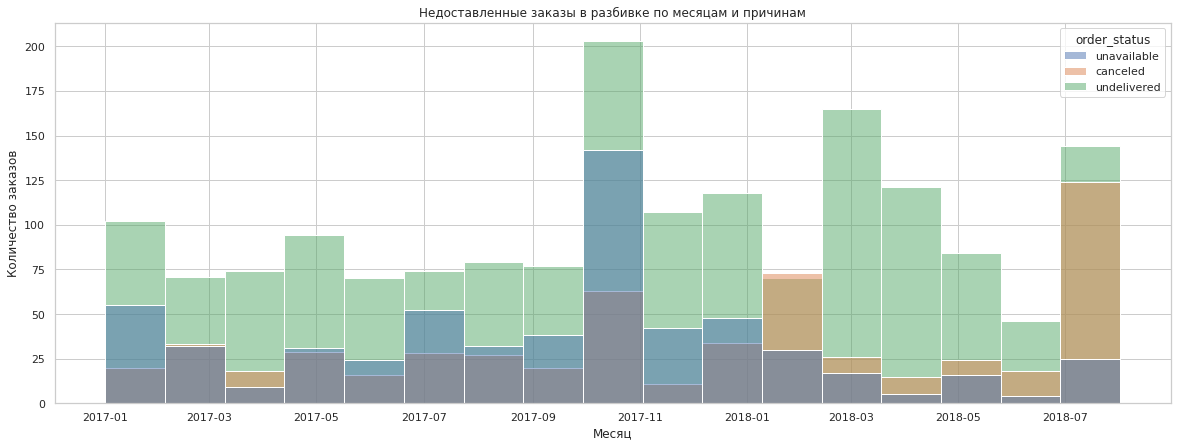

In [21]:
sns.histplot(data=undelivered, x='month', hue='order_status')
plt.title("Недоставленные заказы в разбивке по месяцам и причинам")
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")

In [22]:
month = undelivered['month'].nunique()
undelivered_per_month = undelivered.groupby(['order_status'], as_index=False)\
                                   .agg({'month': 'count'})\
                                   .rename(columns={'month': 'orders'})
undelivered_per_month['per_month'] = (undelivered_per_month.orders / month).round(0)
undelivered_per_month.loc['Total'] = undelivered_per_month.sum(numeric_only=True)
undelivered_per_month

,order_status,orders,per_month
0,canceled,579.0,29.0
1,unavailable,602.0,30.0
2,undelivered,1699.0,85.0
Total,NaN,2880.0,144.0


Посмотрим на каких стадиях чаще всего отменяется заказ: за все время 1 заказ был отменен после доставки, 464 заказа были отменены в процессе доставки и по 115 заказам не было получено подтверждение оплаты.
Можно порекомендовать внимательнее изучить работу службы доставки, так как большое количество заказов (85 в месяц) не доставляется в срок, а 23 заказа в месяц отменяются в процессе доставки (возможно тоже из-за задержки доставки).

In [23]:
a = order_2.query('order_status=="canceled"').isna().sum()
cancel_stage = pd.DataFrame({'cause': ['canceled after delivery',
                                       'canceled during delivery process ',
                                       'not approved purchase'],
                             'value': [order_2.query('order_status=="canceled"')
                                       .fillna(0).shape[0]-a[6],
                                       order_2.query('order_status=="canceled"')
                                       .fillna(0).shape[0]-a[4],
                                       a[4]
                                       ]
                             })
cancel_stage['per_month'] = (cancel_stage.value / month).round(0)
cancel_stage

,cause,value,per_month
0,canceled after delivery,1,0.0
1,canceled during delivery process,464,23.0
2,not approved purchase,115,6.0


## Задание 3 <a name="paragraph4"></a>
**По каждому товару определить, в какой день недели товар чаще всего покупается.**

*Ответ: в таблице под кодом*

In [24]:
products = order_2.query('order_status=="delivered"')\
                  .merge(item, how='right', on='order_id')
products['week_day'] = products['order_purchase_timestamp'].dt.day_name()
products_max = products.groupby(['product_id', 'week_day'])\
                       .agg({'order_status': 'count'})\
                       .rename(columns={'order_status': 'count_max'})
products = products.merge(products_max, how='left', on='product_id')
max_weekday = products.groupby(['product_id', 'week_day'], as_index=False)\
                      .agg({'order_status': 'count', 'count_max': 'max'})
max_weekday.query('count_max==order_status').groupby('product_id')\
           .apply(lambda x: ','.join(x['week_day']))\
           .to_frame()\
           .reset_index().rename(columns={0: 'max_weekday'})

,product_id,max_weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000d9be29b5207b54e86aa1b1ac54872,Tuesday
4,0011c512eb256aa0dbbb544d8dffcf6e,Thursday
...,...,...
21640,fff28f91211774864a1000f918ed00cc,Wednesday
21641,fff515ea94dbf35d54d256b3e39f0fea,Sunday
21642,fff81cc3158d2725c0655ab9ba0f712c,Monday
21643,fff9553ac224cec9d15d49f5a263411f,Friday


## Задание 4 <a name="paragraph5"></a>

**Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

*Ответ: таблица под кодом*

In [25]:
orders_per_week = customer_order\
                  .query('order_status=="delivered" &\
                          order_approved_at!="NaN"')
orders_per_week['weeks'] = orders_per_week.order_approved_at\
                                          .dt.days_in_month / 7
orders_per_week = orders_per_week.groupby(['month',
                                           'customer_unique_id'],
                                          as_index=False)\
                                 .agg({'order_status': 'count',
                                       'weeks': 'mean'})
orders_per_week['per_week'] = (orders_per_week.order_status / orders_per_week.weeks).round(2)
orders_per_week.sort_values('per_week', ascending=False).head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,month,customer_unique_id,order_status,weeks,per_week
62,2017-01-01,12f5d6e1cbf93dafd9dcc19095df0b3d,6,4.428571,1.35
51277,2018-02-01,3e43e6105506432c953e165fb2acf44c,4,4.000000,1.00
1714,2017-02-01,a239b8e2fbce33780f1f1912e2ee5275,4,4.000000,1.00
54251,2018-02-01,b4e4f24de1e8725b74e4a1f4975116ed,4,4.000000,1.00
24407,2017-09-01,b08fab27d47a1eb6deda07bfd965ad43,4,4.285714,0.93


In [26]:
orders_per_week = pd.pivot(orders_per_week, index='customer_unique_id',
                           columns='month', values='per_week')\
                    .fillna(0)

(orders_per_week
 .head(5)
 .style
 .format('{:.1f}', na_rep='-')
 .highlight_null(null_color='lightgrey')
 .highlight_max(color='yellowgreen', axis=1)
 )

month,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00
customer_unique_id,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 5 <a name="paragraph6"></a>

**Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.**

*Ответ: самый высокий retention на третий месяц у когорты 2017-03 и он составляет 0,5%. В целом мы видим, что большинство пользователей не возвращаются в магазин, это один из вопросов для дальнейшего исследования.*

Для когортного анализа выберем следующие параметры: 
- признак формирования когорты: месяц первой покупки
- отчетный период: январь-декабрь 2017г.
- показатель: количество клиентов, совершивших повторные покупки

In [27]:
first_order = customer_order.query('order_status=="delivered" &\
                                    order_approved_at!="NaN"')\
                            .groupby('customer_unique_id', as_index=False)\
                            .agg({'order_purchase_timestamp': 'min'})\
                            .rename(columns={'order_purchase_timestamp': 'first_order'})
cohorts = customer_order.query('order_status=="delivered" &\
                                order_approved_at!="NaN"')\
                        .merge(first_order,
                               how='left',
                               on='customer_unique_id')\
                        .query('first_order>="2017-01-01" &\
                                first_order<="2017-12-31"')\
           [['order_id', 'customer_unique_id', 'first_order', 'order_purchase_timestamp']]
cohorts['delta'] = (cohorts.order_purchase_timestamp - cohorts.first_order)\
                    .map(lambda x: round(x.days / 30))
cohorts['cohort'] = cohorts.first_order.dt.to_period("M")
cohorts['month'] = cohorts.order_purchase_timestamp.dt.to_period("M")
cohorts = cohorts.groupby(['cohort', 'delta'], as_index=False)\
                 .agg({'order_id': 'nunique'})
cohorts = cohorts.pivot(index='cohort', columns='delta', values='order_id')
cohorts = cohorts.div(cohorts.iloc[:, 0], axis=0)

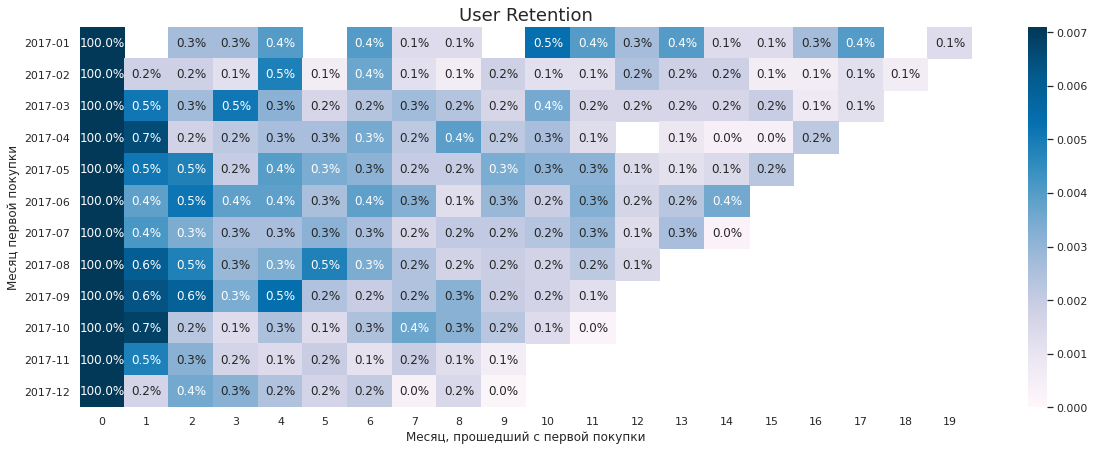

In [28]:
sns.heatmap(cohorts, annot=True, vmin=0.0, vmax=0.0071, cmap="PuBu", fmt='.1%')
plt.title('User Retention', fontsize=18)
plt.xlabel('Месяц, прошедший с первой покупки')
plt.ylabel('Месяц первой покупки')
sns.set(
    style="whitegrid",
    rc={'figure.figsize': (20, 10)}
        )

In [29]:
cohorts[[3]].idxmax()

delta
3    2017-03
dtype: period[M]

## Задание 6 RFM-анализ <a name="paragraph7"></a>

**Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.**


Рассмотрим частоту покупок для установки градаций для показателя frequency. Для данного распределения значений количества покупок я принимаю решение установить следующие интервалы: 1) одна покупка 2) две покупки 3) три покупки 4) четыре покупки 5) пять и более покупок. И  в соответствии с категориями выставляю баллы от 1 (самый худший, одна покупка) до 5 (самый лучший, более пяти покупок).

In [30]:
frequency = customer_order.query('order_status=="delivered" &\
                                  order_approved_at!="NaN"')\
                            .groupby('customer_unique_id', as_index=False)\
                            .agg({'order_id': 'count'})\
                            .groupby('order_id', as_index=False)\
                            .size()\
                            .rename(columns={'order_id': 'number_of_orders'})
frequency

,number_of_orders,size
0,1,90295
1,2,2561
2,3,180
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


In [31]:
RFM = customer_order.query('order_status=="delivered" &\
                            order_approved_at!="NaN"')\
                            .groupby('customer_unique_id', as_index=False)\
                            .agg({'order_id': 'count'})\
                            .rename(columns={'order_id': 'number_of_orders'})
print(RFM.shape[0])


def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x == 4:
        return 4
    else:
        return 5


RFM['F'] = RFM['number_of_orders'].apply(lambda x:f_score(x))

93083


Далее оценю показатель `monetary` - сумму заказов каждого пользователя. Величина выручки носит непрерывный характер, поэтому удобнее оценки расставить по квинтилям. Рассчитаю выручку на пользователя, добавлю оценку по квинтилю 
 - при выручке до 39,9  оценка 1
 - при выручке от 40 до 69,9 оценка 2
 - при выручке от 70 до 109,9 оценка 3
 - при выручке от 110 до 179,9 оценка 4
 - при выручке от 180 и выше оценка 5

В данных по frequency и monetary одинаковое количество уникальных покупателей - 93 083.

In [32]:
monetary = customer_order.query('order_status=="delivered" &\
                                 order_approved_at!="NaN"')\
                            .merge(item, how='left', on='order_id')\
                            .groupby('customer_unique_id', as_index=False)\
                            .agg({'price': 'sum'})\
                            .rename(columns={'price': 'revenue'})
print(monetary.shape[0])
quintilesM = monetary['revenue'].quantile([.2, .4, .6, .8]).to_dict()
print(quintilesM)


def m_score(x):
    if x <= quintilesM[.2]:
        return 1
    elif x <= quintilesM[.4]:
        return 2
    elif x <= quintilesM[.6]:
        return 3
    elif x <= quintilesM[.8]:
        return 4
    else:
        return 5


monetary['M'] = monetary['revenue'].apply(lambda x:m_score(x))
RFM = RFM.merge(monetary, how = 'inner', on = 'customer_unique_id')

93083
{0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}


Далее исследуем показатель recency - давность совершения покупки. Последней датой буду считать самую позднюю дату в столбце даты доставки покупателю (рассчитывала ранее). Также расставляем оценки по квинтилям:

- при давности заказа до 139 дней оценка 5
- при давности заказа от 139 до 224 дней оценка 4
- при давности заказа от 225 до 315 дней оценка 3
- при давности заказа от 316 до 428 дней оценка 2
- при давности заказа свыше 429 дней оценка 1


In [33]:
recency = customer_order.query('order_status=="delivered" &\
                                order_approved_at!="NaN"')\
                        .groupby('customer_unique_id', as_index=False)\
                        .agg({'order_approved_at': 'max'})\
                        .rename(columns={'order_approved_at': 'last_date'})
recency['days'] = (max_date - recency.last_date).dt.days

In [34]:
quintilesR = recency['days'].quantile([.2, .4, .6, .8]).to_dict()


def r_score(x):
    if x <= quintilesR[.2]:
        return 5
    elif x <= quintilesR[.4]:
        return 4
    elif x <= quintilesR[.6]:
        return 3
    elif x <= quintilesR[.8]:
        return 2
    else:
        return 1


recency['R'] = recency['days'].apply(lambda x: r_score(x))
RFM = RFM.merge(recency, how='inner', on='customer_unique_id')
print(quintilesR)
RFM

{0.2: 139.0, 0.4: 224.0, 0.6: 315.0, 0.8: 428.0}


,customer_unique_id,number_of_orders,F,revenue,M,last_date,days,R
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,4,2018-05-10 11:11:18,160,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,1,2018-05-07 18:25:44,162,4
2,0000f46a3911fa3c0805444483337064,1,1,69.00,2,2017-03-10 21:05:03,585,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,1,2017-10-12 20:49:17,369,2
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,5,2017-11-14 20:06:52,336,2
...,...,...,...,...,...,...,...,...
93078,fffcf5a5ff07b0908bd4e2dbc735a684,1,1,1570.00,5,2017-06-08 21:15:16,495,1
93079,fffea47cd6d3cc0a88bd621562a9d061,1,1,64.89,2,2017-12-10 20:16:20,310,3
93080,ffff371b4d645b6ecea244b27531430a,1,1,89.90,3,2017-02-07 16:02:44,616,1
93081,ffff5962728ec6157033ef9805bacc48,1,1,115.00,4,2018-05-02 15:58:47,167,4


In [36]:
RFM = RFM.rename(columns={'M_x': 'M'})
RFM = RFM[['customer_unique_id', 'R', 'F', 'M']].astype(str)
RFM['score'] = RFM['R'] + RFM['F'] + RFM['M']
RFM.score.nunique()

80

RFM-анализ позволяет распределять пользователей по группам для различных целей и задачю Например,можно отобрать несколько групп по следующим критериям: показатель F>=2 - посмотрю только на тех пользователей, кто совершил покупку повторно. R=5 - и последняя покупка была сделана в последние 139 дней. Показатель M возьму любой, так как меня интересуют те покупатели, кто совершил повторную покупку на любую сумму.

In [44]:
RFM[['R', 'F', 'M']] = RFM[['R', 'F', 'M']].astype(int)
RFM_trunc = RFM.query('F>=2 and R==5')
RFM_trunc

,customer_unique_id,R,F,M,score
242,00a39521eb40f7012db50455bf083460,5,2,3,523
437,012a218df8995d3ec3bb221828360c86,5,2,5,525
466,013ef03e0f3f408dd9bf555e4edcdc0a,5,2,5,525
544,0178b244a5c281fb2ade54038dd4b161,5,2,5,525
723,01f2285f85a1c603eb7ef755ad311769,5,2,5,525
...,...,...,...,...,...
91452,fb7e29c65321441231990afc201c1b14,5,2,5,525
91481,fb920961e4d8e55fd9c357976a611765,5,2,2,522
91693,fc24db02becd484accefaa5af59c18b1,5,2,5,525
92438,fe3e52de024b82706717c38c8e183084,5,2,3,523


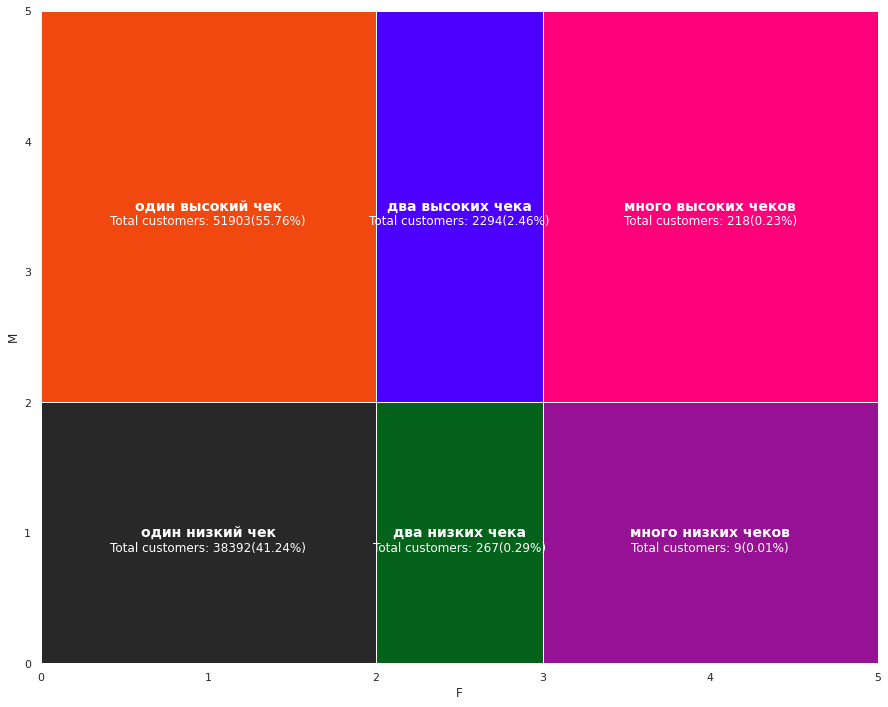

In [56]:
# визуализирую группы
segt_map = {
    r'[1][1-2]': 'один низкий чек',
    r'[2][1-2]': 'два низких чека',
    r'[3-5][1-2]': 'много низких чеков',
    r'[1][3-5]': 'один высокий чек',
    r'[2][3-5]': 'два высоких чека',
    r'[3-5][3-5]': 'много высоких чеков'    
}
RFM['Segment'] = RFM['F'].map(str) + RFM['M'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
rfm_coordinates = {"один низкий чек": [0, 2, 0, 0.4],
                   "два низких чека": [0, 2, 0.4, 0.6],
                   "много низких чеков": [0,2, 0.6, 1],
                   "один высокий чек": [2, 5, 0, 0.4],
                   "два высоких чека": [2, 5, 0.4, 0.6],
                   "много высоких чеков": [2, 5, 0.6, 1],
                   }

fig, ax = plt.subplots(figsize=(15, 12))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"]="white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, facecolor=color)
    
    users = RFM[RFM.Segment==key].shape[0]
    users_percentage = (RFM[RFM.Segment==key].shape[0] / RFM.shape[0]) * 100
        
    user_txt = "\n\nTotal customers: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
       
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x=x, y=y, s=key, ha="center", va="center", fontsize=14, color="white", fontweight="bold")
    plt.text(x=x, y=y, s=user_txt, ha="center", va="center", fontsize=12, color="white")    
        
    ax.set_xlabel("F")
    ax.set_ylabel("M")
    
sns.despine(left = True, bottom = True)
plt.show()

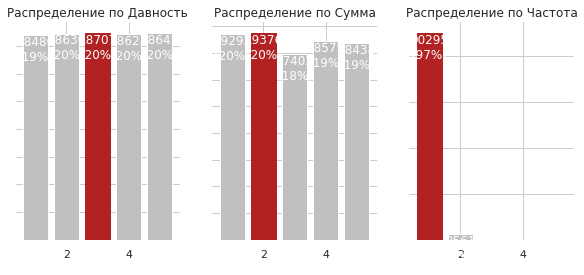

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, p in enumerate(['R', 'M','F']):
    parameters = {'R': 'Давность', 'M': 'Сумма','F': 'Частота'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение по {}'.format(parameters[p]),
                fontsize=12)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()


Исходя из графика можно сделать вывод, что пользователи равномерно распределяются по показателям суммы и давности покупки, но есть большой перекос в распределении по частоте. Большая часть пользователей (97%) совершают только одну покупку и не возвращаются больше в магазин. Таким образом, нужно выяснить причины этого и обратить внимание на программы лояльности, повышения качества обслуживания.

## Выводы и рекомендации <a name="paragraph8"></a>

Были проанализированы данные о продажах в интернет-магазине: проведен предварительный анализ данных, рассчитаны запрошенные показатели, проведен когортный и RFM-анализ. На основе анализа можно сделать следующие выводы:
1. Рекоменуется внимательнее изучить работу службы доставки, так как большое количество заказов (85 в месяц, 1,4% от общего числа заказов) не доставляется в срок, а 23 заказа в месяц отменяются в процессе доставки (возможно тоже из-за задержки доставки). Также в последние месяцы отмечается рост отмены заказов, в причинах чего тоже нужно детально разобраться.
2. Рекомендуется разработать программы лояльности для клиентов, для повышения вероятности повторных покупок с их стороны. Через несколько месяцев после внедрения программ лояльности рекомендуется провести когортный и RFM-анализ для сравнения изменения показателей повторных покупок.
3. Проведенный RFM-анализ был недостаточно надежен, так как большинство пользователей совершили только одну покупку, но он в том числе показал, что у в магазине очень много таких пользователей и это является точкой роста в данном случае. 
